# Импорты

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install pytorch_lightning
    !pip install gensim
    !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [2]:
import subprocess

import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

# Нейронные сети - база

In [3]:
X = torch.tensor([10, 5, 20]).float()

num_inputs = 3
num_outputs = 1
neuron = nn.Linear(num_inputs, num_outputs)
neuron(X)

tensor([-11.3977], grad_fn=<ViewBackward0>)

In [4]:
num_outputs = 1
neuron = nn.Linear(num_inputs, num_outputs)
neuron(X)

tensor([4.5094], grad_fn=<ViewBackward0>)

In [5]:
act = torch.nn.ReLU()
act(torch.tensor([12.0])), act(torch.tensor([-11.0]))

(tensor([12.]), tensor([0.]))

In [6]:
num_outputs = 10
neuron = torch.nn.Linear(num_inputs, num_outputs)
act(neuron(X))

tensor([ 8.5955,  0.0000,  0.0000,  0.0000,  6.4938,  7.7873,  0.0000,  0.0000,
        16.9449,  6.2332], grad_fn=<ReluBackward0>)

In [7]:
network = nn.Sequential(
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
)
network(X)

tensor([0.0000, 4.1240, 0.0000, 0.0000, 5.7533], grad_fn=<ReluBackward0>)

Определим НН и обучим ее на простом датасете

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 321    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

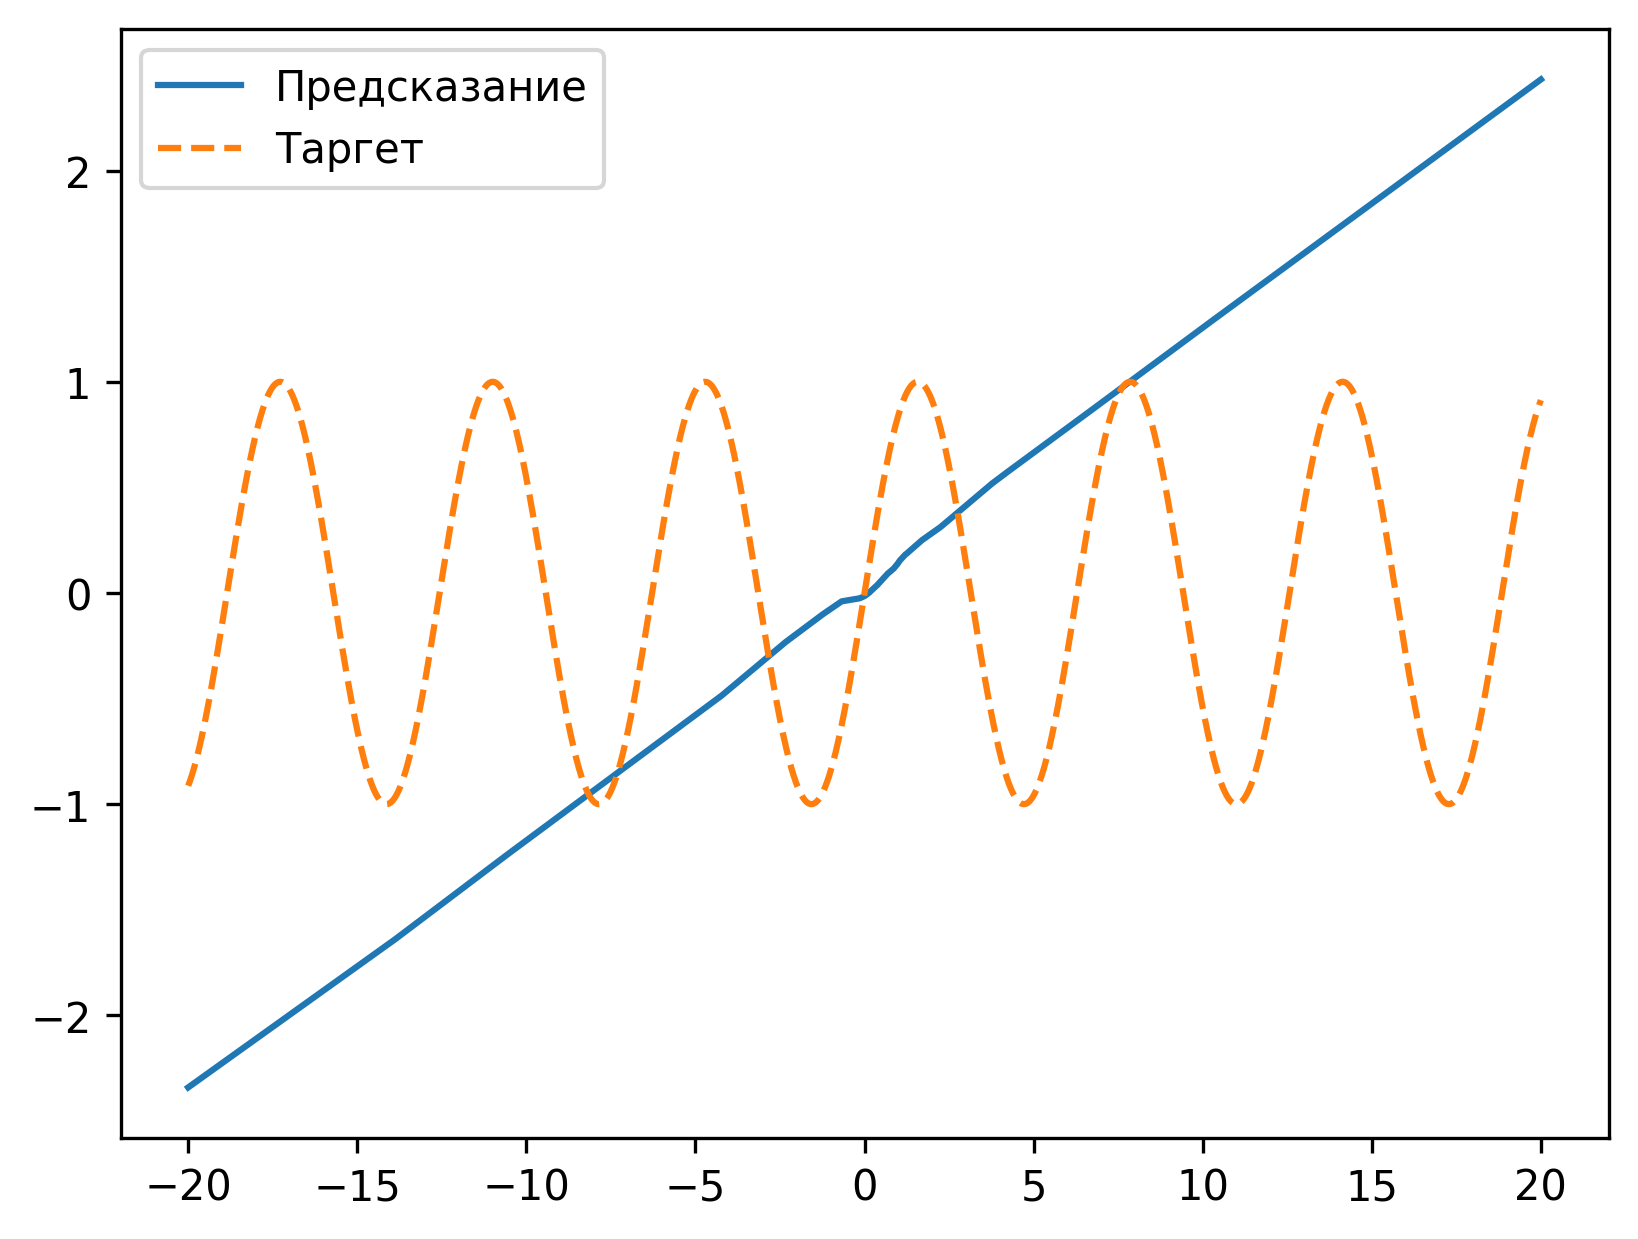

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

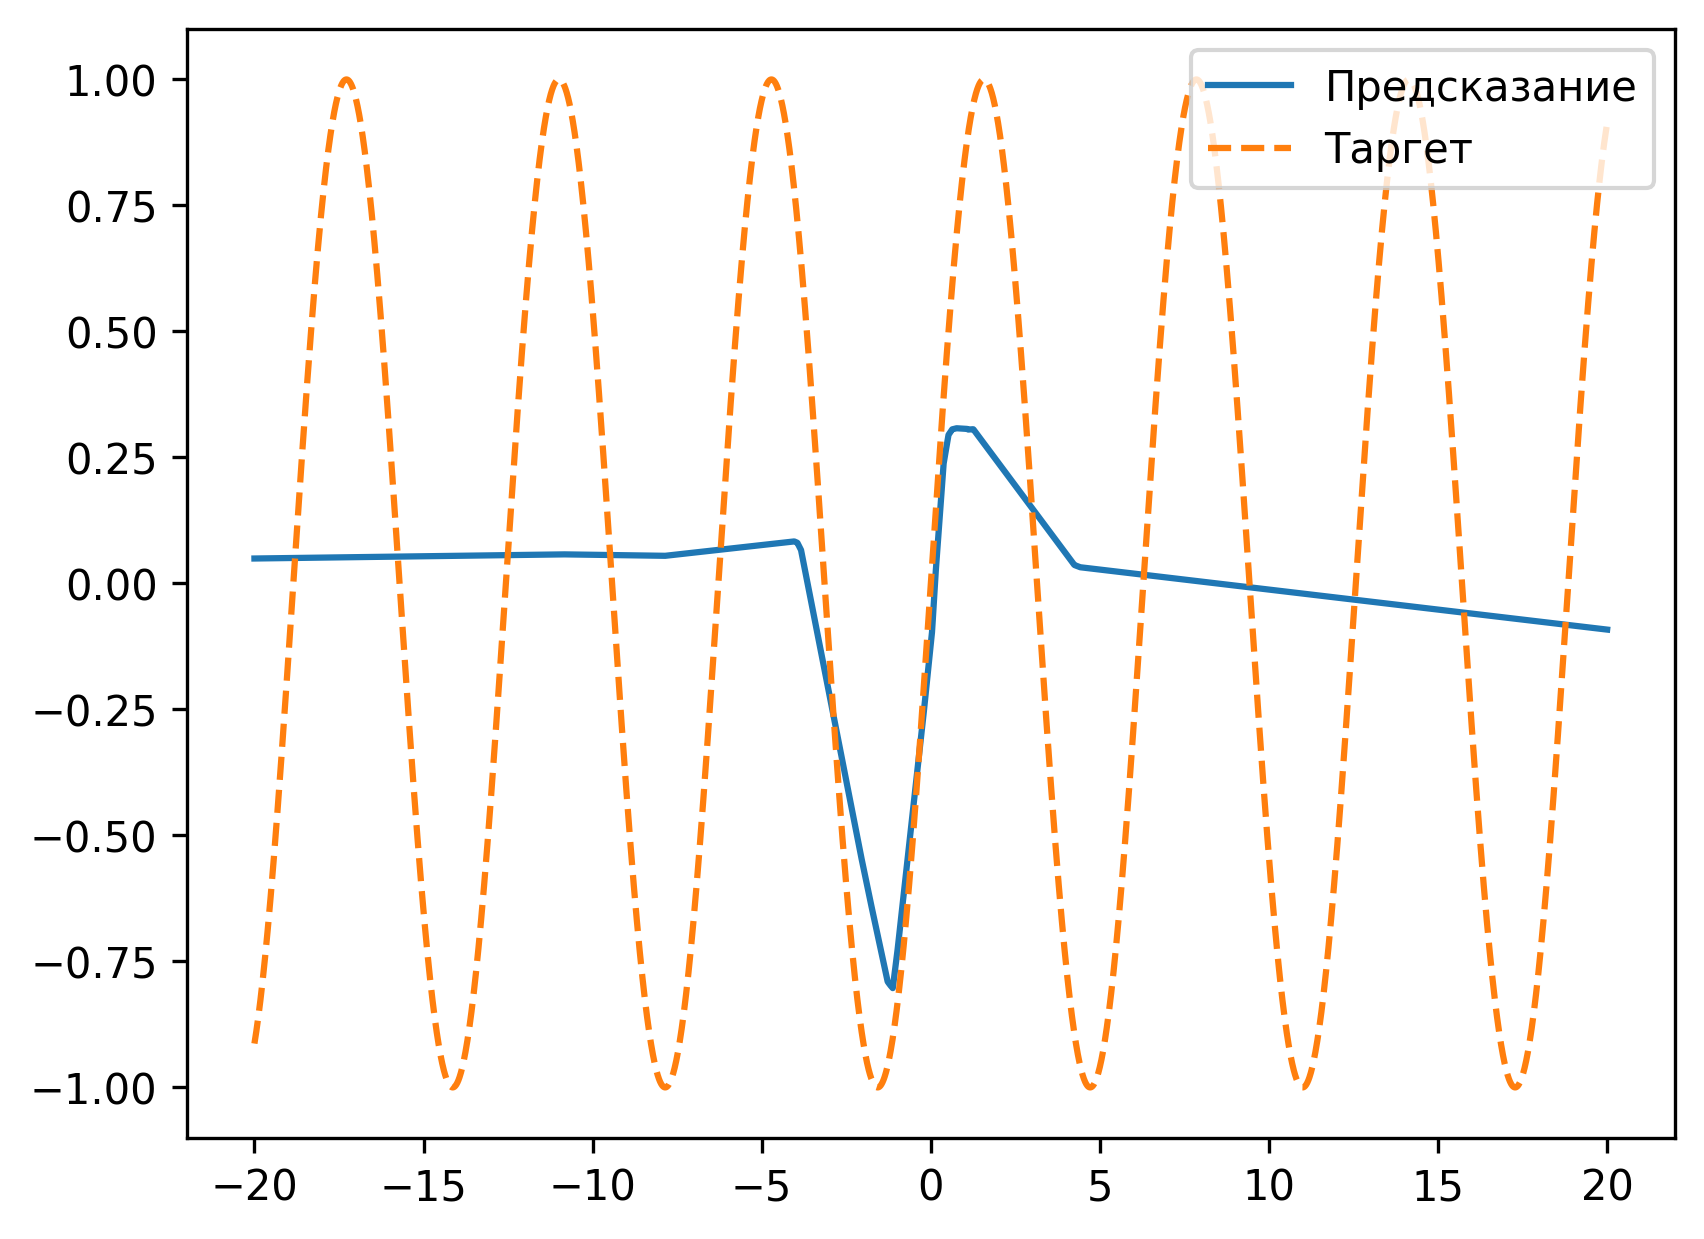

Validation: |          | 0/? [00:00<?, ?it/s]

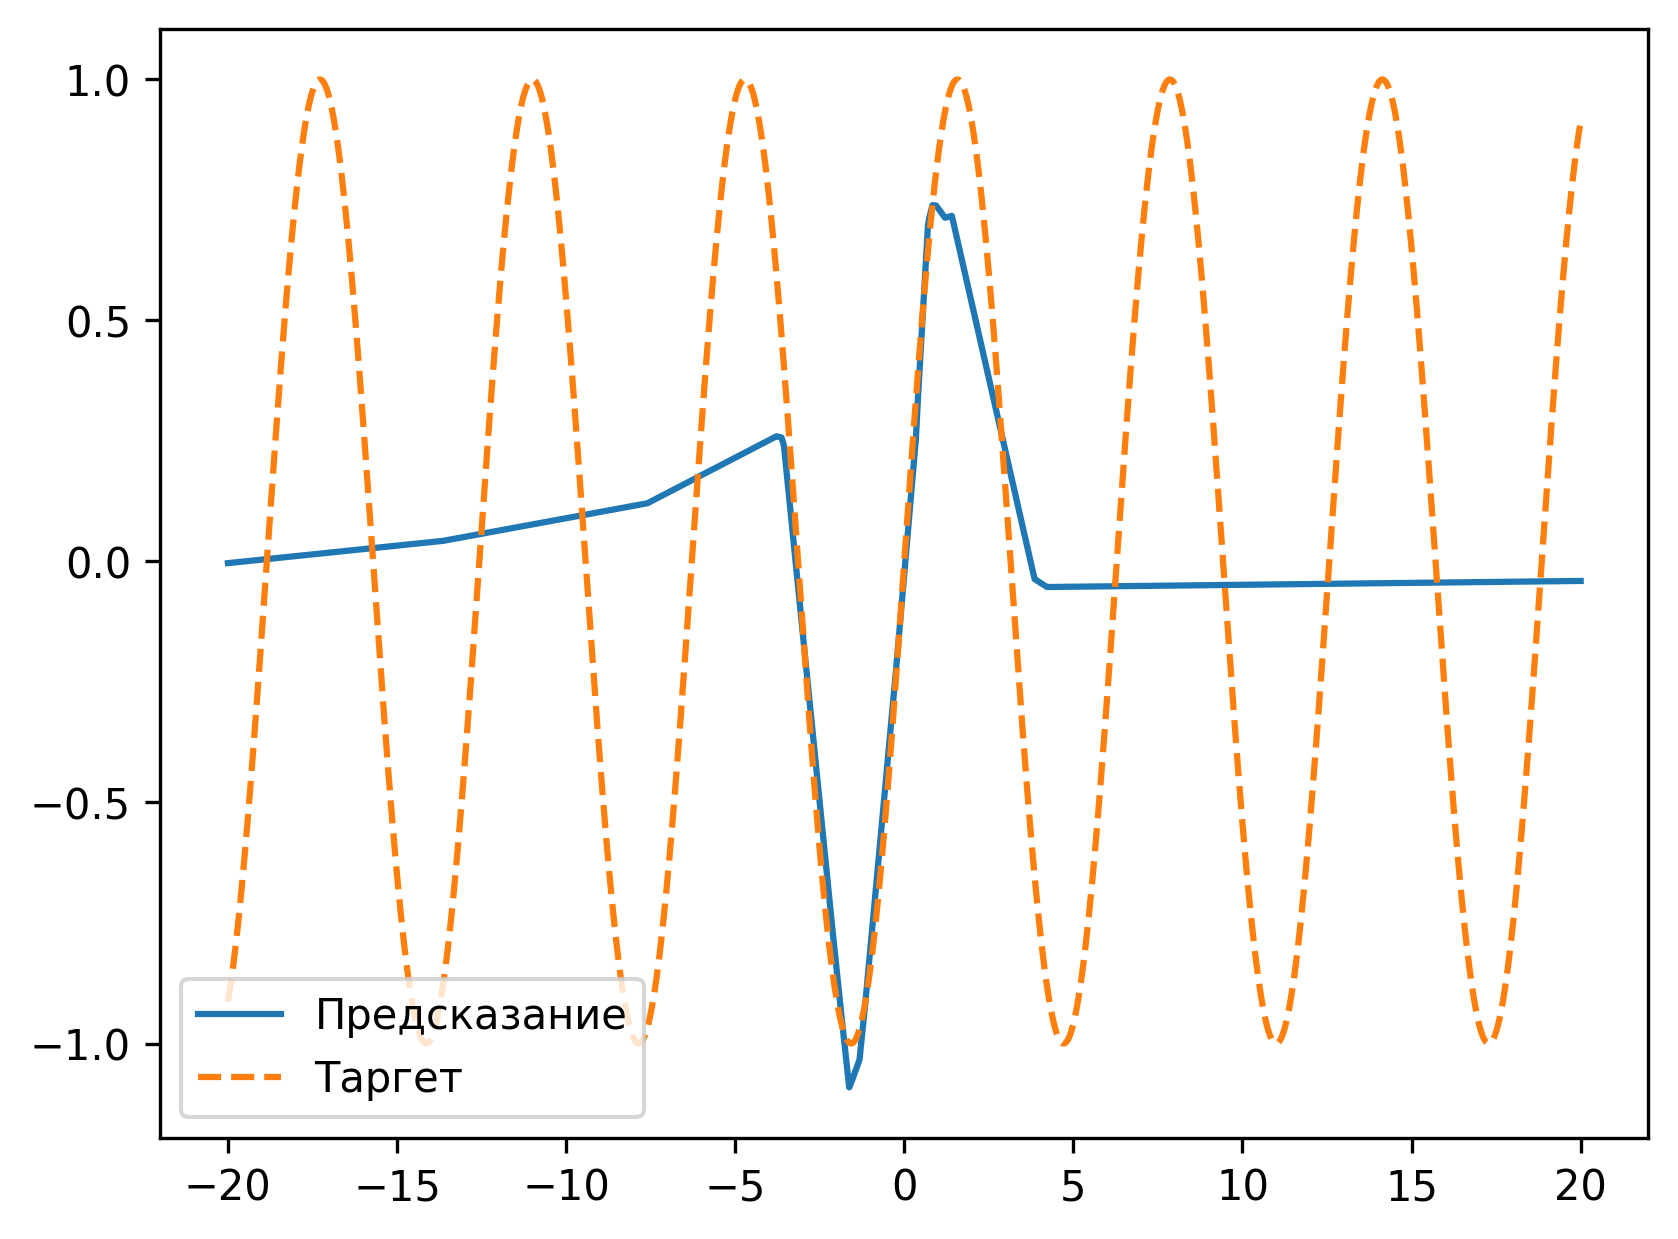

Validation: |          | 0/? [00:00<?, ?it/s]

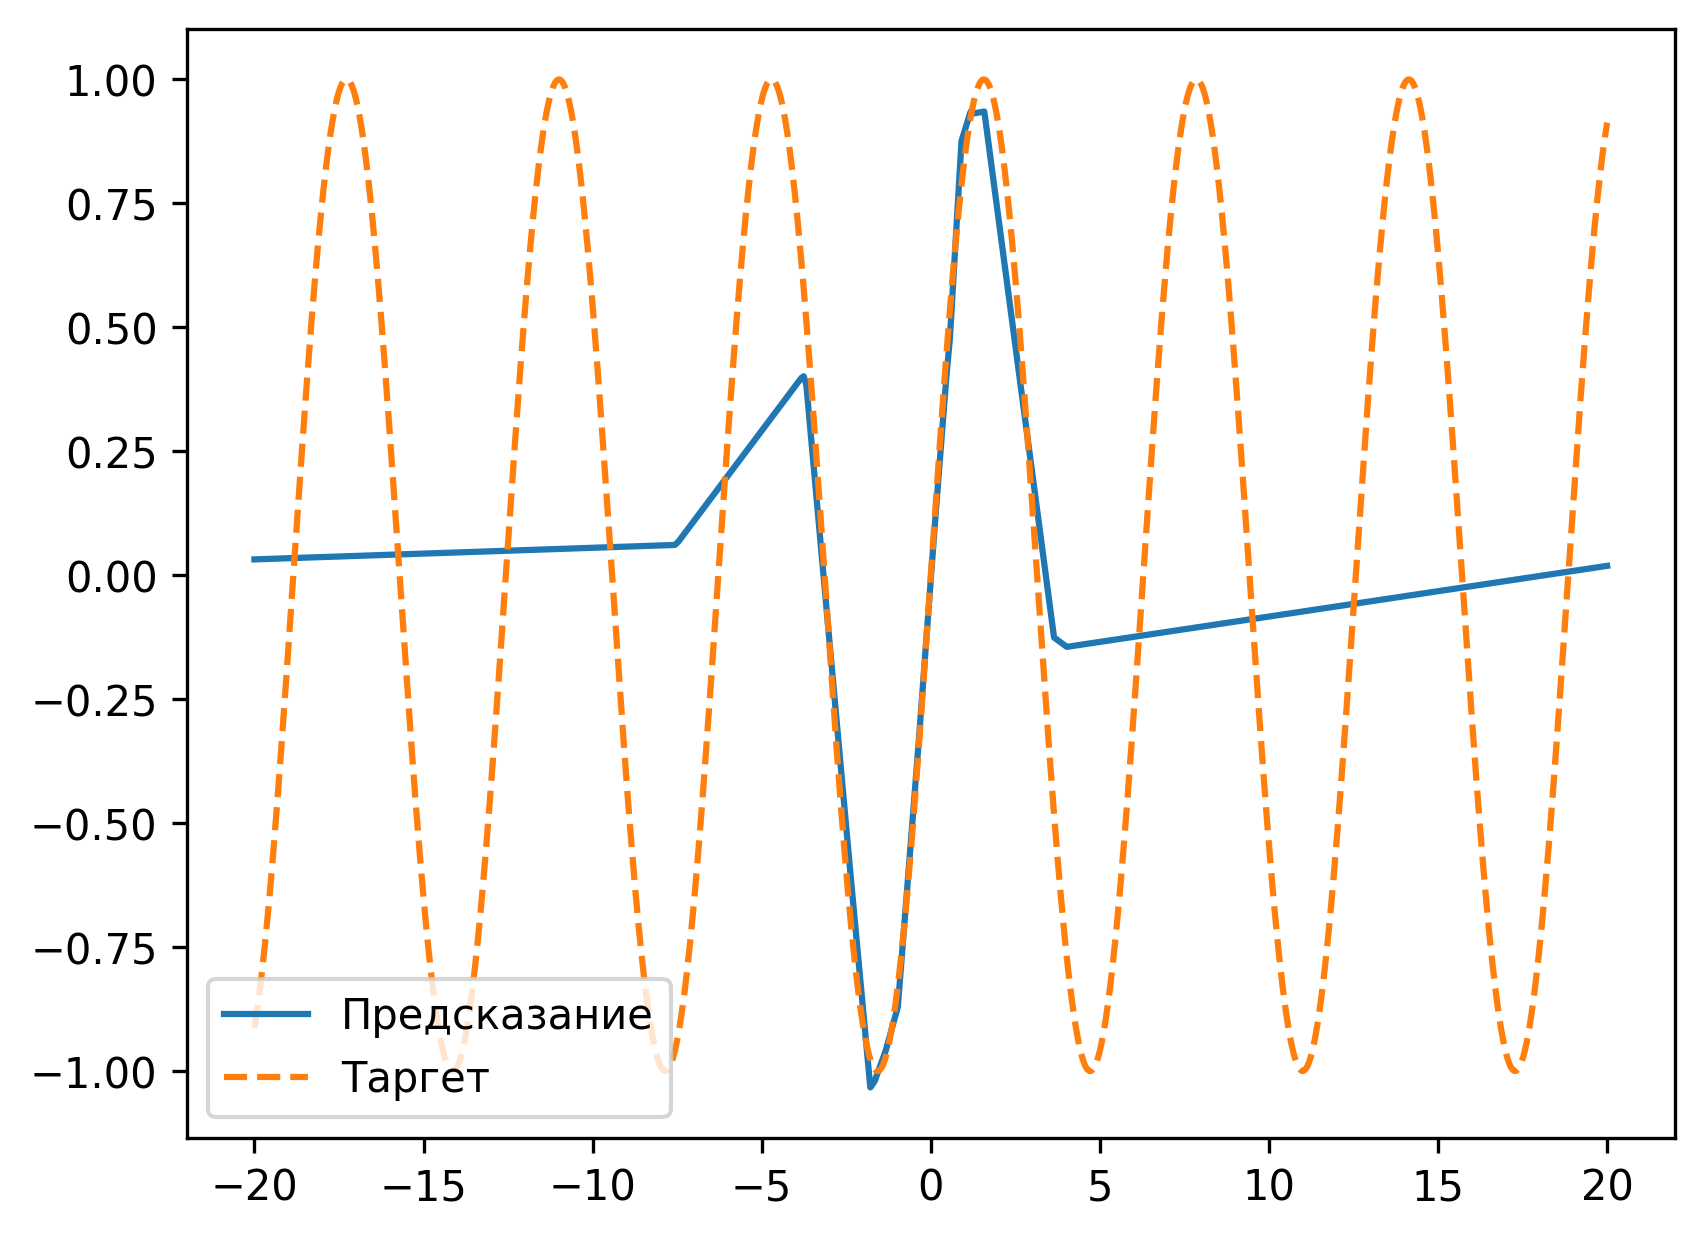

Validation: |          | 0/? [00:00<?, ?it/s]

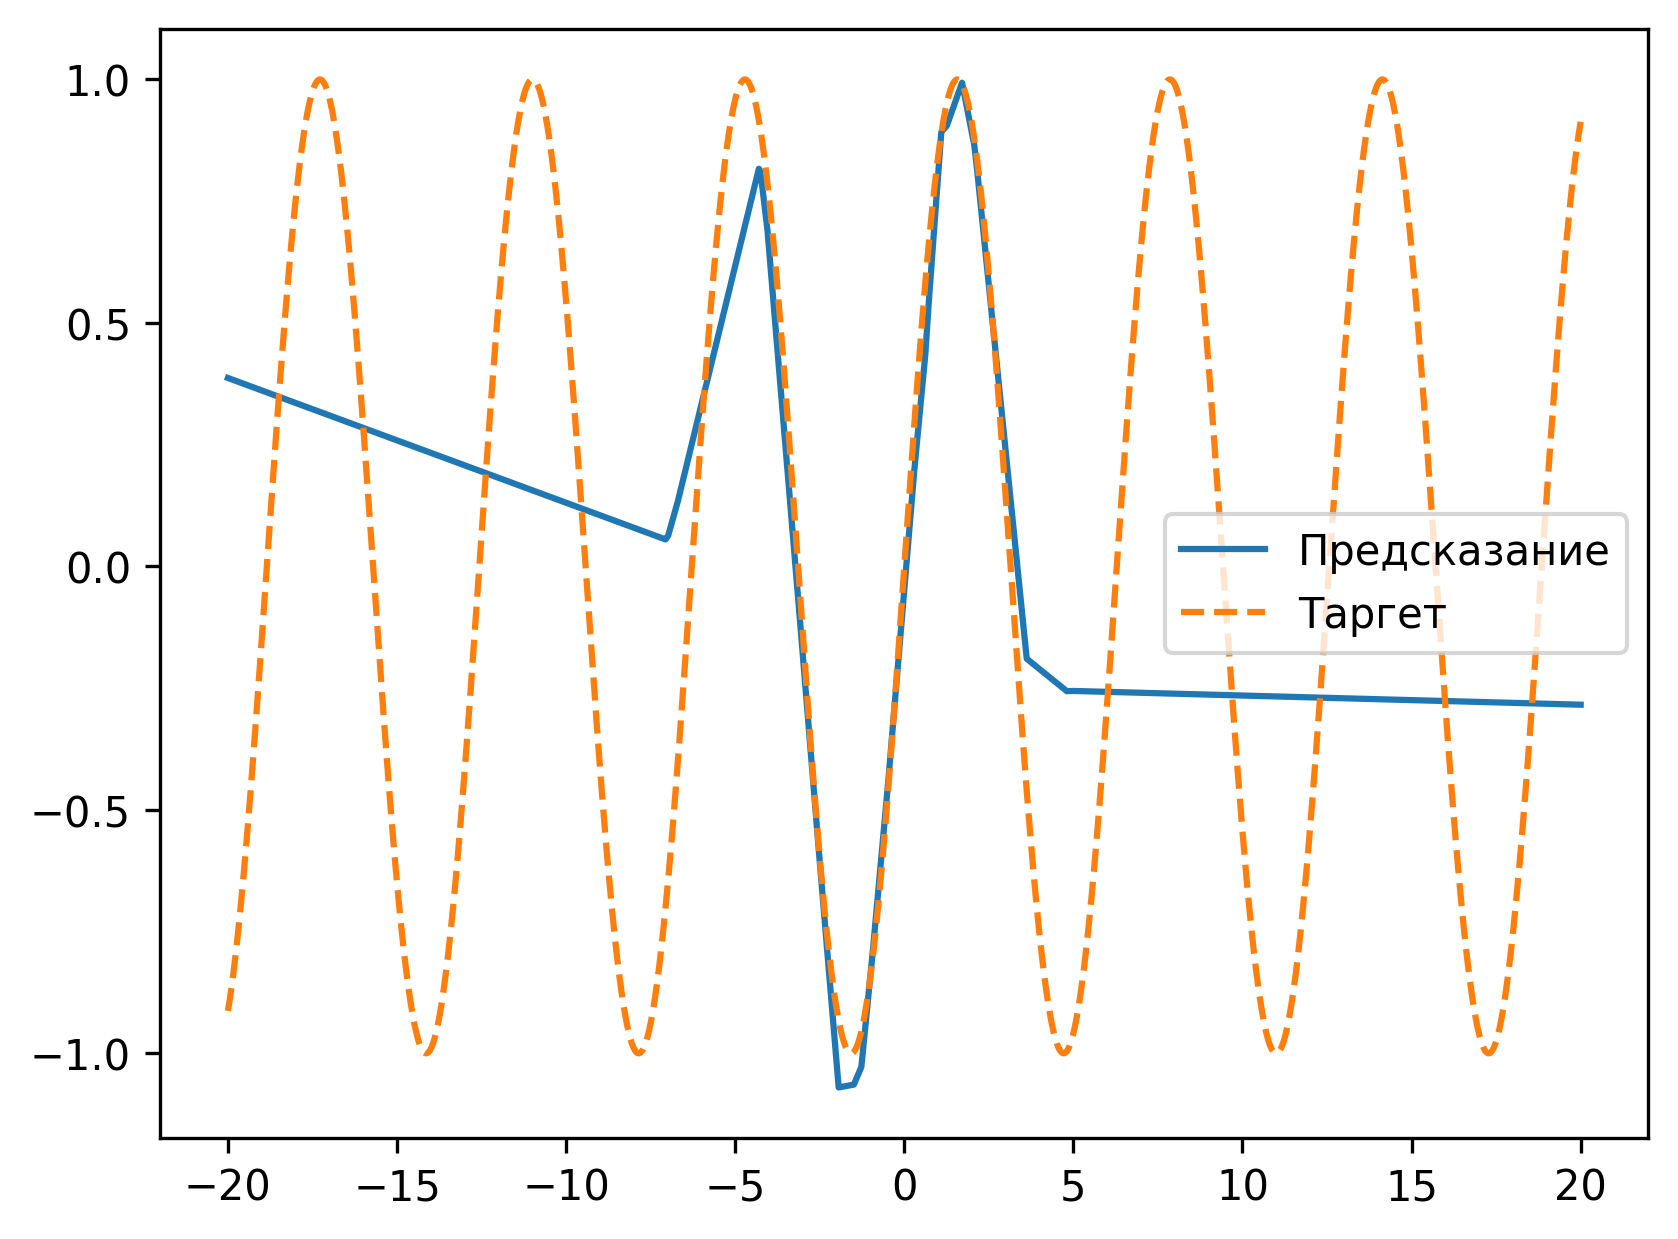

Validation: |          | 0/? [00:00<?, ?it/s]

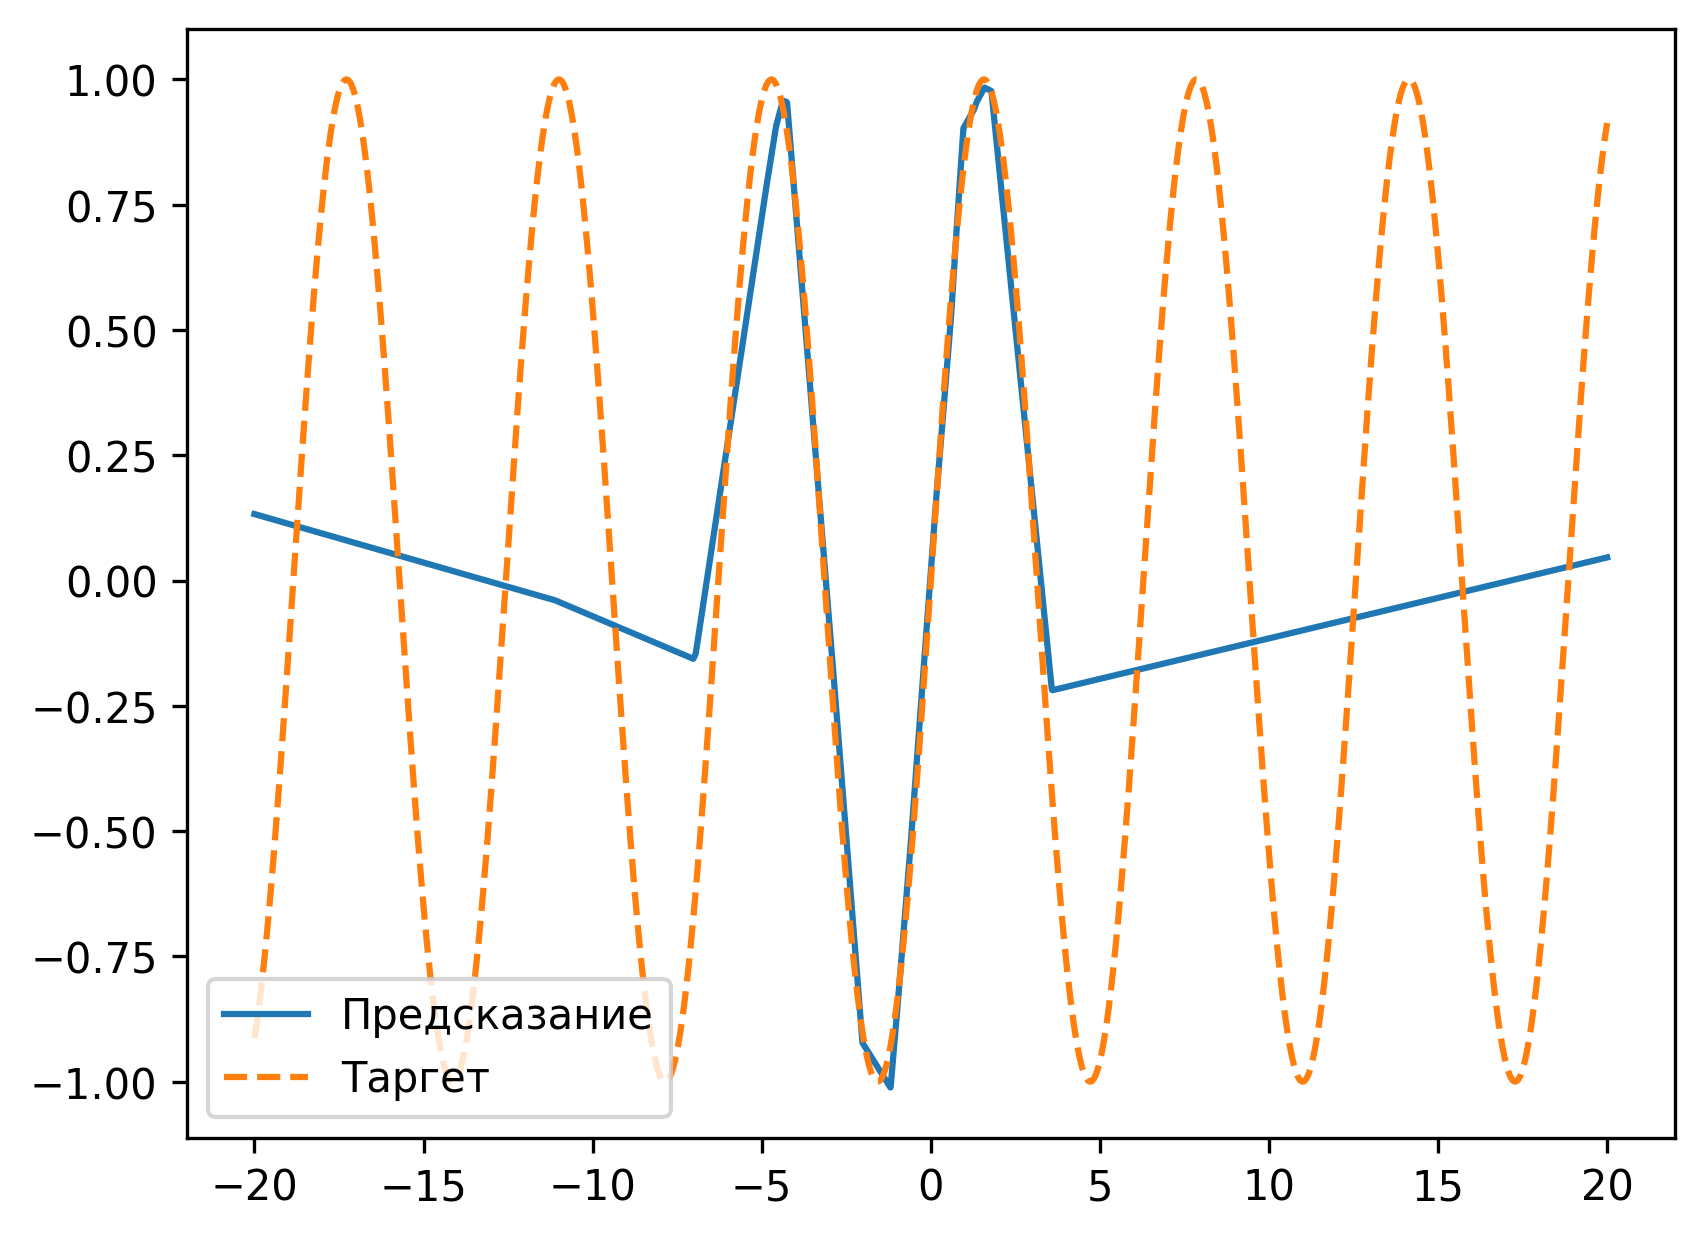

Validation: |          | 0/? [00:00<?, ?it/s]

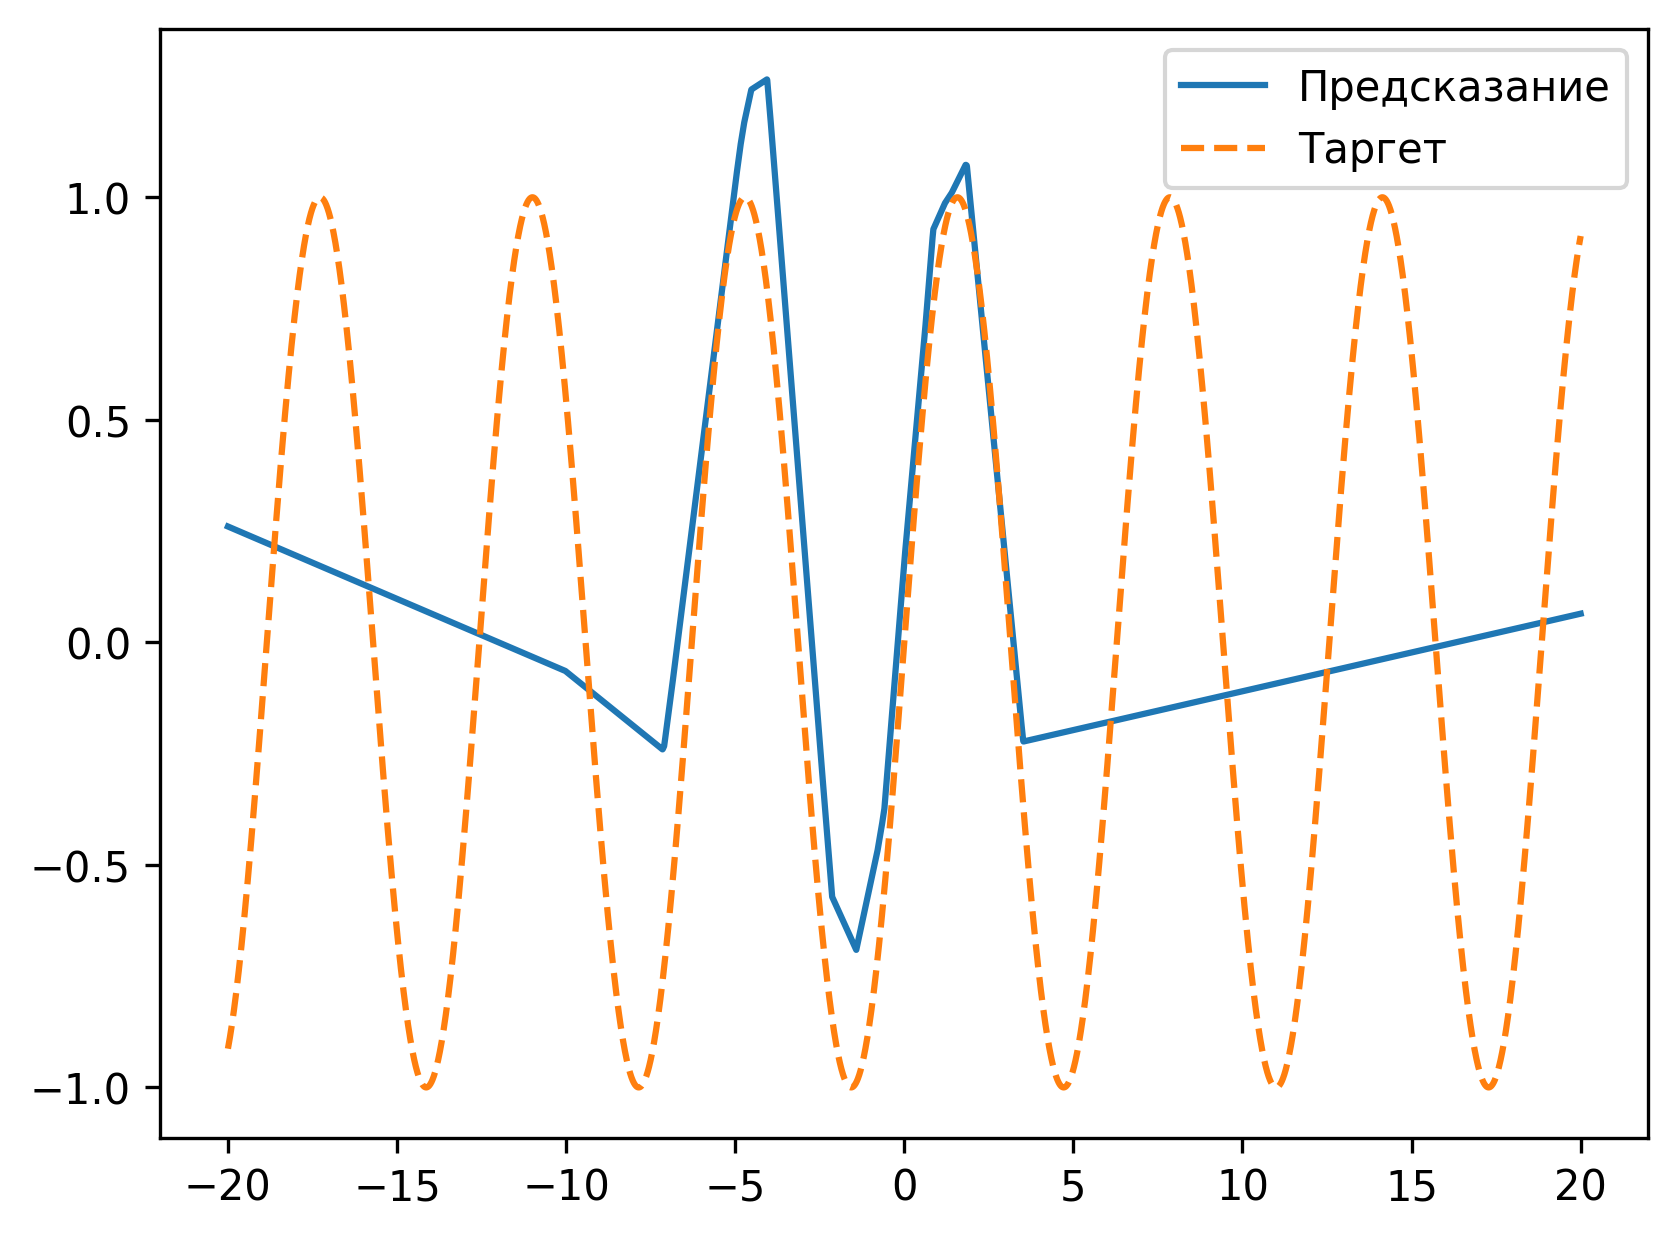

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


In [20]:
class SinDataset(Dataset):
    def __init__(self, start, end, num_samples):
        self.x = torch.linspace(start, end, num_samples)[:, None]
        self.y = torch.sin(self.x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class SinModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        return loss

    @torch.no_grad
    def validation_step(self, batch):
        x, y = batch
        pred = self(x)

        x = x.flatten().cpu()
        y = y.flatten().cpu()
        pred = pred.flatten().cpu().detach()

        plt.plot(x, pred, label="Предсказание")
        plt.plot(x, y, linestyle="--", label="Таргет")
        plt.legend()
        plt.show()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)


dataset = SinDataset(start=-20, end=20, num_samples=5000)
dataloader = DataLoader(dataset, batch_size=1000)
val_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

model = SinModel()
trainer = pl.Trainer(max_epochs=300, check_val_every_n_epoch=50)
trainer.fit(model, dataloader, val_dataloader)

__Задача__: попробуйте изменить архитектуру нн так, чтобы она предсказала правильно два цикла (например, значения на интервале -5, 7)

# Эмбеддинги для слов

In [21]:
import gensim.downloader as api
import numpy as np
import nltk

nltk.download("punkt_tab", quiet=True)
from nltk.tokenize import sent_tokenize, word_tokenize


def get_embeddings(model, text):
    """Get Word2Vec embeddings for the given text."""
    # Split the text into words and get embeddings for each word
    words = word_tokenize(text)
    word_to_embed = {}

    for word in words:
        if word in model:
            word_to_embed[word] = model[word]
        else:
            word_to_embed[word] = None

    return word_to_embed


text = "did not see you there dfdfdf"
embed_model = api.load("glove-wiki-gigaword-50")

word_embed_dict = get_embeddings(embed_model, text)

for word, embedding in word_embed_dict.items():
    print(f"{word} - {embedding}")

[==================================================] 100.0% 66.0/66.0MB downloaded
did - [ 0.042523  -0.21172    0.044739  -0.19248    0.26224    0.0043991
 -0.88195    0.55184   -0.64939   -0.17511    0.1225     0.68355
 -0.82141   -0.35839    0.96636    0.54873    0.065911  -0.4903
 -0.26302   -0.66737   -0.2046     0.37963    0.52251   -0.26308
  0.40828   -2.2215    -0.5848    -0.26058    0.30964   -0.95756
  3.0448     0.37217   -0.68005   -0.60398    0.13016   -0.29502
  0.51808    0.29607    0.19795   -0.15422   -0.22707    0.16382
 -0.092931   0.2265     0.036166  -0.0059486 -0.34131    0.12102
 -0.23999    0.46656  ]
not - [ 5.5025e-01 -2.4942e-01 -9.3860e-04 -2.6400e-01  5.9320e-01  2.7950e-01
 -2.5666e-01  9.3076e-02 -3.6288e-01  9.0776e-02  2.8409e-01  7.1337e-01
 -4.7510e-01 -2.4413e-01  8.8424e-01  8.9109e-01  4.3009e-01 -2.7330e-01
  1.1276e-01 -8.1665e-01 -4.1272e-01  1.7754e-01  6.1942e-01  1.0466e-01
  3.3327e-01 -2.3125e+00 -5.2371e-01 -2.1898e-02  5.3801e-01 -5.0615

In [23]:
import gensim.downloader as api

available_models = api.info()["models"].keys()

print("Available embedding models:\n", *available_models, sep="\n")

Available embedding models:

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


__Задача__: найдите слово, у которого эмбеддинг ближе всего к значению: $v_{man} + v_{queen} - v_{king}$, где $v_{word}$ - эмбеддинг слова `word`

## Twitter sentiment classification

[Ссылка на датасет](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset?select=Twitter_Data.csv)

In [24]:
df = pd.read_csv("Twitter_Data.csv")
df = df.sample(frac=0.25, random_state=42)
df

,clean_text,category
45849,sir also staunch modi supporter but you should...,0.0
131657,aloo factory productions,0.0
65437,because they are pigs who were born raised lut...,1.0
41980,indian modi plans national broadcast wednesday\n,0.0
39625,narendra modi spearhead bjps election campaign...,0.0
...,...,...
73777,just like you shikhar dhawan others mission sh...,0.0
111026,vote for new bharat says modi telangana public...,1.0
161657,bjp wont get any seat west bengal says mamata ...,0.0
118668,hearing fugitive diamantaire nirav modis bail ...,0.0


In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm


def preprocess(df, embed_model):
    embeds = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        word_embed_dict = get_embeddings(embed_model, row["clean_text"])

        row_embeds = [e for e in word_embed_dict.values() if e is not None]
        if row_embeds:
            # Среднее эмбеддингов в тексте
            embeds.append(np.stack(row_embeds).mean(0))
        else:
            embeds.append(np.zeros(embed_model.vector_size))

    X = np.stack(embeds)
    return X


df = df.dropna()
X = preprocess(df, embed_model)
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = CatBoostClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_test)



  0%|          | 0/40745 [00:00<?, ?it/s]

  1%|          | 292/40745 [00:00<00:13, 2918.10it/s]

  1%|▏         | 584/40745 [00:00<00:14, 2711.90it/s]

  2%|▏         | 857/40745 [00:00<00:14, 2665.15it/s]

  3%|▎         | 1138/40745 [00:00<00:14, 2719.85it/s]

  4%|▎         | 1450/40745 [00:00<00:13, 2859.78it/s]

  4%|▍         | 1737/40745 [00:00<00:13, 2861.73it/s]

  5%|▍         | 2024/40745 [00:00<00:13, 2855.84it/s]

  6%|▌         | 2329/40745 [00:00<00:13, 2913.36it/s]

  6%|▋         | 2638/40745 [00:00<00:12, 2967.12it/s]

  7%|▋         | 2935/40745 [00:01<00:14, 2522.97it/s]

  8%|▊         | 3199/40745 [00:01<00:16, 2297.78it/s]

  8%|▊         | 3440/40745 [00:01<00:17, 2139.38it/s]

  9%|▉         | 3662/40745 [00:01<00:17, 2076.53it/s]

 10%|▉         | 3875/40745 [00:01<00:17, 2053.15it/s]

 10%|█         | 4084/40745 [00:01<00:18, 2034.09it/s]

 11%|█         | 4290/40745 [00:01<00:17, 2036.42it/s]

 11%|█         | 4496/40745 [00:01<00:18, 2009.84it/s]

 12%|█

Learning rate set to 0.093663
0:	learn: 1.0793996	total: 150ms	remaining: 2m 29s
1:	learn: 1.0642335	total: 212ms	remaining: 1m 45s
2:	learn: 1.0513034	total: 297ms	remaining: 1m 38s
3:	learn: 1.0393697	total: 377ms	remaining: 1m 33s
4:	learn: 1.0292159	total: 450ms	remaining: 1m 29s
5:	learn: 1.0199858	total: 489ms	remaining: 1m 20s
6:	learn: 1.0119714	total: 532ms	remaining: 1m 15s
7:	learn: 1.0053307	total: 571ms	remaining: 1m 10s
8:	learn: 0.9986560	total: 616ms	remaining: 1m 7s
9:	learn: 0.9922953	total: 659ms	remaining: 1m 5s
10:	learn: 0.9866506	total: 699ms	remaining: 1m 2s
11:	learn: 0.9812627	total: 739ms	remaining: 1m
12:	learn: 0.9763489	total: 792ms	remaining: 1m
13:	learn: 0.9729414	total: 832ms	remaining: 58.6s
14:	learn: 0.9697274	total: 873ms	remaining: 57.3s
15:	learn: 0.9658906	total: 915ms	remaining: 56.3s
16:	learn: 0.9627518	total: 957ms	remaining: 55.3s
17:	learn: 0.9599357	total: 996ms	remaining: 54.4s
18:	learn: 0.9570906	total: 1.04s	remaining: 53.5s
19:	learn

In [26]:
f1_score(y_true=y_test, y_pred=pred, average="micro")

0.6020377807526401

In [27]:
class TwitterDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor((y + 1).to_numpy(), dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class TwitterModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 16),
            nn.ReLU(),
            # nn.Linear(16, 16),
            # nn.ReLU(),
            # nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = self.forward(x)
        x = x.argmax(dim=1)
        return x

    def training_step(self, batch):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        return loss

    @torch.no_grad
    def validation_step(self, batch):
        x, y = batch
        pred = self.predict(x)
        x = x.flatten().cpu()
        y = y.flatten().cpu()
        pred = pred.flatten().cpu().detach()

        f1 = f1_score(y_true=y, y_pred=pred, average="micro")
        print(f"f1: {f1}")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)


train_dataset = TwitterDataset(X_train, y_train)
test_dataset = TwitterDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=12000, shuffle=False)

model = TwitterModel()
trainer = pl.Trainer(max_epochs=300, check_val_every_n_epoch=50)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 1.7 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


f1: 0.21966666666666668
f1: 0.21922544951590595


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

f1: 0.5838333333333333
f1: 0.5643153526970954


Validation: |          | 0/? [00:00<?, ?it/s]

f1: 0.5851666666666666
f1: 0.5698478561549101


Validation: |          | 0/? [00:00<?, ?it/s]

f1: 0.5819166666666666
f1: 0.5781466113416321


Validation: |          | 0/? [00:00<?, ?it/s]

f1: 0.581
f1: 0.5746887966804979


Validation: |          | 0/? [00:00<?, ?it/s]

f1: 0.5813333333333334
f1: 0.5774550484094052


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


f1: 0.5835833333333333
f1: 0.5774550484094052
